# Exercise 8: ResNets with and without BN

In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import os
from PIL import Image
import ast
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import copy
import pickle

os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# Transforms for training and testing. We use the CIFAR 10 means
# and stdevs from https://github.com/facebookarchive/fb.resnet.torch/issues/180

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.262)),
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.491, 0.482, 0.447), (0.247, 0.243, 0.262)),
])

# Load the CIFAR-10 dataset

train_dataset = torchvision.datasets.CIFAR10(root='./data', transform=train_transforms, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', transform=test_transforms, train=False, download=True)

# Category labels

cat_labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

# Create data loaders from train/test datasets

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=128)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

dataloaders = {'train': train_dataloader, 'val': test_dataloader}

/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


Files already downloaded and verified
Files already downloaded and verified


Let's make a simple ResNet with two basic blocks, manually.

In [2]:
import torch.nn.functional as F

class ResNetManual(torch.nn.Module):
    def __init__(self, use_bn=False, num_classes=10):
        super().__init__()
        self.use_bn = use_bn
        # Initial convolution
        self.conv0 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=(not use_bn))
        if use_bn:
            self.bn0 = torch.nn.BatchNorm2d(32)
        # Initial residual block
        self.conv1 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=(not use_bn))
        if use_bn:
            self.bn1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1, bias=(not use_bn))
        if use_bn:
            self.bn2 = torch.nn.BatchNorm2d(32)
        # Second residual block
        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=(not use_bn))
        if use_bn:
            self.bn3 = torch.nn.BatchNorm2d(64)
        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=(not use_bn))
        if use_bn:
            self.bn4 = torch.nn.BatchNorm2d(64)
        self.identity = torch.nn.Conv2d(32, 64, kernel_size=1, stride=2, padding=0, bias=(not use_bn))
        if use_bn:
            self.identity_bn = torch.nn.BatchNorm2d(64)
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
        self.linear = torch.nn.Linear(64, num_classes)

    def forward(self, x):
        # Initial convolution
        
        x = self.conv0(x)
        if self.use_bn:
            x = self.bn0(x)
        x = F.relu(x)
        
        # First residual block
        
        out = self.conv1(x)
        if self.use_bn:
            out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        if self.use_bn:
            out = self.bn2(out)
        x = x + out
        x = F.relu(x)
        
        # Second residual block
        
        out = self.conv3(x)
        if self.use_bn:
            out = self.bn3(out)
        out = F.relu(out)
        out = self.conv4(out)
        if self.use_bn:
            out = self.bn4(out)
        x = self.identity(x)
        if self.use_bn:
            x = self.identity_bn(x)
        x = x + out
        x = F.relu(x)
        
        x = self.avgpool(x)
        bs, nc, _, _ = x.shape
        x = x.view(bs, nc)
        x = self.linear(x)
        
        return x



In [3]:
# from tqdm import tqdm

# # Load models

# model1 = ResNetManual(use_bn=False)
# model2 = ResNetManual(use_bn=True)

# # Training loop

# device = 'cuda:3'
# model1 = model1.to(device)
# num_epochs = 100
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

# train_losses = []
# test_losses = []

# def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, weights_name='weight_save', is_inception=False):
    
# for epoch in range(num_epochs):
#     # Iterate over the training data loader
#     model1.train()
#     epoch_loss = 0
#     iters = 0
#     for inputs, targets in tqdm(train_dataloader):
#         model1.zero_grad()
#         inputs = inputs.to(device)
#         targets = targets.to(device)
#         outputs = model1(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.cpu().item()
#         iters += 1
#     print('Epoch %d training loss %f' % (epoch, epoch_loss / iters))
#     train_losses.append(epoch_loss / iters)
#     model1.eval()
#     epoch_loss = 0
#     iters = 0
#     with torch.no_grad():
#         for inputs, targets in tqdm(test_dataloader):
#             inputs = inputs.to(device)
#             targets = targets.to(device)
#             outputs = model1(inputs)
#             loss = criterion(outputs, targets)
#             epoch_loss += loss.cpu().item()
#             iters += 1
#     print('Epoch %d test loss %f' % (epoch, epoch_loss / iters))
#     test_losses.append(epoch_loss / iters)


In [4]:
def top1_error(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels.data)
    return 1 - correct / len(labels)
def train_model(model, dataloaders, criterion, optimizer, num_epochs, weights_name='weight_save', is_inception=False):
    since = time.time()

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    train_errors = []
    val_errors = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_error = 0.0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_error += top1_error(outputs, labels) * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            epoch_error = running_error / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
                train_errors.append(epoch_error)
            else:
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
                val_errors.append(epoch_error)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, weights_name)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, train_acc_history, train_errors, val_loss_history, val_acc_history, val_errors




In [5]:
from tqdm import tqdm

# Load models

model1 = ResNetManual(use_bn=False)
model2 = ResNetManual(use_bn=True)

# Training loop

device = 'cuda:3'
num_epochs = 50
criterion = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)



## 1. With BN

In [6]:

_, train_loss_history1, train_acc_history1, train_errors1, val_loss_history1, val_acc_history1, val_errors1 = train_model(model1, dataloaders, criterion, optimizer1, num_epochs, weights_name='weight_save', is_inception=False)

Epoch 1/50
----------
train Loss: 2.0297 Acc: 0.2323
val Loss: 1.8065 Acc: 0.2960

Epoch 2/50
----------
train Loss: 1.7413 Acc: 0.3341
val Loss: 1.6936 Acc: 0.3468

Epoch 3/50
----------
train Loss: 1.6372 Acc: 0.3829
val Loss: 1.5622 Acc: 0.4197

Epoch 4/50
----------
train Loss: 1.5387 Acc: 0.4305
val Loss: 1.5008 Acc: 0.4594

Epoch 5/50
----------
train Loss: 1.4692 Acc: 0.4633
val Loss: 1.4013 Acc: 0.4869

Epoch 6/50
----------
train Loss: 1.3980 Acc: 0.4913
val Loss: 1.3884 Acc: 0.5042

Epoch 7/50
----------
train Loss: 1.3332 Acc: 0.5198
val Loss: 1.3384 Acc: 0.4960

Epoch 8/50
----------
train Loss: 1.2756 Acc: 0.5422
val Loss: 1.2720 Acc: 0.5358

Epoch 9/50
----------
train Loss: 1.2222 Acc: 0.5628
val Loss: 1.1795 Acc: 0.5799

Epoch 10/50
----------
train Loss: 1.1632 Acc: 0.5856
val Loss: 1.1519 Acc: 0.5843

Epoch 11/50
----------
train Loss: 1.1218 Acc: 0.6019
val Loss: 1.0722 Acc: 0.6111

Epoch 12/50
----------
train Loss: 1.0858 Acc: 0.6167
val Loss: 1.0646 Acc: 0.6224

E

<function matplotlib.pyplot.show(close=None, block=None)>

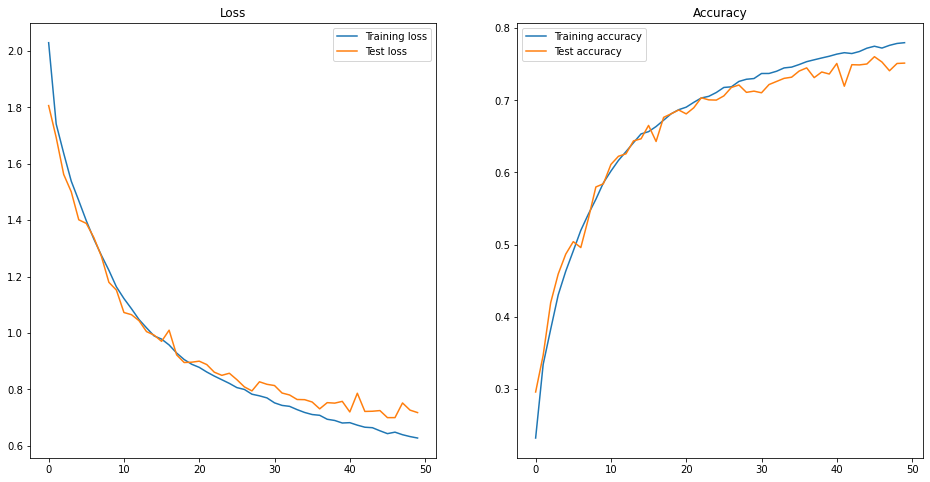

In [7]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history1, label='Training loss')
plt.plot(val_loss_history1, label='Test loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in train_acc_history1], label='Training accuracy')
plt.plot([x.cpu() for x in val_acc_history1], label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show

## 2. Without BN

In [9]:
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
_, train_loss_history2, train_acc_history2, train_errors2, val_loss_history2, val_acc_history2, val_errors2 = train_model(model2, dataloaders, criterion, optimizer2, num_epochs, weights_name='weight_save', is_inception=False)


Epoch 1/50
----------
train Loss: 1.6346 Acc: 0.4003
val Loss: 1.4457 Acc: 0.4762

Epoch 2/50
----------
train Loss: 1.2817 Acc: 0.5381
val Loss: 1.2497 Acc: 0.5463

Epoch 3/50
----------
train Loss: 1.1285 Acc: 0.5978
val Loss: 1.1079 Acc: 0.6078

Epoch 4/50
----------
train Loss: 1.0252 Acc: 0.6363
val Loss: 1.1360 Acc: 0.6044

Epoch 5/50
----------
train Loss: 0.9603 Acc: 0.6591
val Loss: 1.0745 Acc: 0.6219

Epoch 6/50
----------
train Loss: 0.9053 Acc: 0.6805
val Loss: 0.9958 Acc: 0.6556

Epoch 7/50
----------
train Loss: 0.8636 Acc: 0.6987
val Loss: 0.9917 Acc: 0.6462

Epoch 8/50
----------
train Loss: 0.8263 Acc: 0.7098
val Loss: 0.9452 Acc: 0.6616

Epoch 9/50
----------
train Loss: 0.7976 Acc: 0.7205
val Loss: 0.9356 Acc: 0.6783

Epoch 10/50
----------
train Loss: 0.7671 Acc: 0.7285
val Loss: 1.0281 Acc: 0.6371

Epoch 11/50
----------
train Loss: 0.7483 Acc: 0.7394
val Loss: 0.9346 Acc: 0.6776

Epoch 12/50
----------
train Loss: 0.7223 Acc: 0.7472
val Loss: 0.9617 Acc: 0.6762

E

<function matplotlib.pyplot.show(close=None, block=None)>

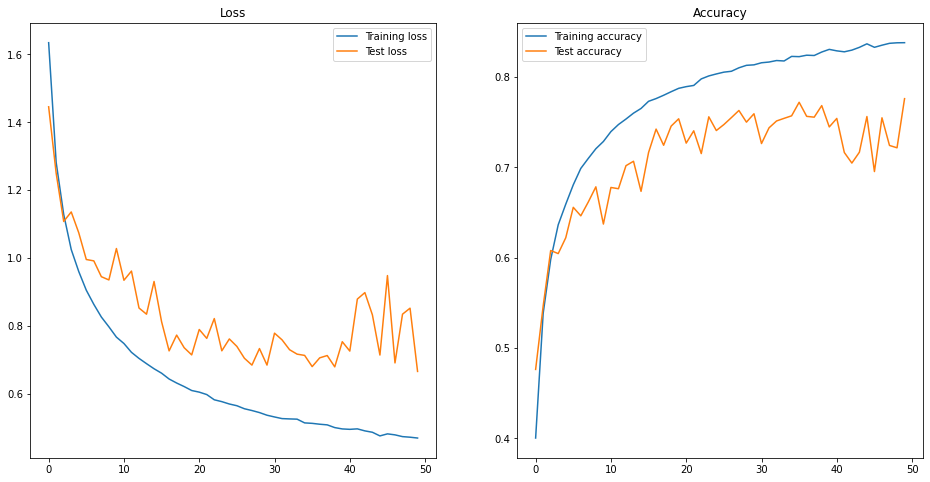

In [10]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history2, label='Training loss')
plt.plot(val_loss_history2, label='Test loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in train_acc_history2], label='Training accuracy')
plt.plot([x.cpu() for x in val_acc_history2], label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show

## Top1-error comparision

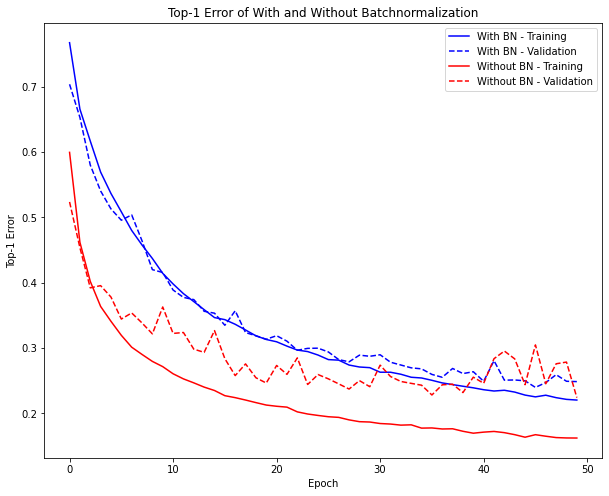

In [11]:
epochs = range(num_epochs)
fig = plt.figure(figsize=(10, 8))
plt.plot(epochs, [x.cpu() for x in train_errors1], 'b-', label='With BN - Training')
plt.plot(epochs, [x.cpu() for x in val_errors1], 'b--', label='With BN - Validation')
plt.plot(epochs, [x.cpu() for x in train_errors2], 'r-', label='Without BN - Training')
plt.plot(epochs, [x.cpu() for x in val_errors2], 'r--', label='Without BN - Validation')
plt.title('Top-1 Error of With and Without Batchnormalization')
plt.xlabel('Epoch')
plt.ylabel('Top-1 Error')
plt.legend()
plt.show()